# Wrangling and Analyzing Data

## 1. Introduction

Data preparation is always the hardest part of a data analyst's work flow, in this project, we will use the data wrangling skills to pull real-world data from Twitter, clean it, and do some analysis. We will get the original Twitter data from Twitter user @dog_rates, along with a image prediction dataset, to build our analysis. 

WeRateDogs is a popular Twitter hash tag, as the name tells, people rate dogs with a denominator of 10 and the numerator is usually higher than 10 to show how lovely the dog is.

## 2. Gathering Data

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import requests
import tweepy
import re
from tweepy import OAuthHandler
from timeit import default_timer as timer

%matplotlib inline

### 2.1 Import the on hand twitter data

In [2]:
twt_df1 = pd.read_csv('twitter-archive-enhanced.csv')
twt_df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2.2 Scrape data from website

In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image_prediction.tsv', mode='wb') as file:
    file.write(response.content)

img_df = pd.read_csv('image_prediction.tsv', sep='\t')

In [4]:
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


I tried to get data from Twitter API by registering a Twitter developer account. But the application was failed, I was rejected by Twitter. So I just used the data sent from my Udacity instructor.

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twt_df1.tweet_id.values
len(tweet_ids)

2356

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

Store the JSON file in a dataframe.

In [7]:
df2_list = []

with open('tweet-json.txt', 'r', encoding='utf8') as file:
    for line in file:
        lines = json.loads(line)
        df2_list.append({'tweet_id': lines['id'],
                        'favorites': lines['favorite_count'],
                        'retweets': lines['retweet_count'],
                        'timestamp': lines['created_at']})
twt_df2 = pd.DataFrame(df2_list, columns=['tweet_id','timestamp','favorites','retweets'])

In [8]:
twt_df2.head()

,tweet_id,timestamp,favorites,retweets
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,25461,4328
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,42908,8964
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,41048,9774


## 3. Assessing Data

Now, it's time to check the data we gathered in part 2.

### 3.1 Assessment

twt_df1

In [10]:
twt_df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
twt_df1.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [9]:
twt_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twt_df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
twt_df1.sort_values('timestamp')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None


There are a lot of missing data in **in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp** columns. Tried to find a connection among them:

In [14]:
twt_df1[twt_df1.in_reply_to_status_id.notna()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [15]:
twt_df1[twt_df1.retweeted_status_id.notna()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


Twt_df1 columns:

* **tweet_id**: the unique identifier for each tweet
* **in_reply_to_status_id**: if the tweet is a reply, this column will representing the original tweet id
* **in_reply_to_user_id**: if the tweet is a reply, this column will representing the original tweet's user id
* **timestamp**: date and time of the tweet
* **source**: utility used to post the tweet
* **text**: content of the tweet 
* **retweeted_status_id**: if the tweet is retweet, this column will representing the original tweet id
* **retweeted_status_user_id**: if the tweet is retweet, this column will representing the original tweet's user id
* **retweeted_status_timestamp**: if the tweet is retweet, this column will representing the original tweet's time stamp
* **expanded_urls**: URL of the tweet
* **rating_numerator**: rating numerator of the dog mentioned in the tweet
* **rating_denominator**: rating denominator of the dog mentioned in the tweet
* **name**: the name of the dog
* **doggo**/ **floofer**/ **pupper**/ **puppo**: some nick names of different dog species at different ages.


img_df

In [16]:
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
img_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [18]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
img_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


img_df columns:

* **tweet_id**: the unique identifier of the tweet
* **jpg_url**: the URL of the image
* **img_num**: image number of the tweet
* **p1**: the first prediction of the image with the most prediction confidence
* **p1_conf**: how confident the algorithm is in the first prediction
* **p1_dog**: whether or not the first prediction is a dog
* **p2**: the second prediction of the image with the second prediction confidence
* **p2_conf**: how confident the algorithm is in the second prediction
* **p2_dog**: whether or not the second prediction is a dog
* **p3**: the third prediction of the image with the third prediction confidence
* **p3_conf**: how confident the algorithm is in the third prediction
* **p3_dog**: whether or not the third prediction is a dog

twt_df2

In [20]:
twt_df2.head()

,tweet_id,timestamp,favorites,retweets
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,25461,4328
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,42908,8964
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,41048,9774


In [21]:
twt_df2.tail()

,tweet_id,timestamp,favorites,retweets
2349,666049248165822465,Mon Nov 16 00:24:50 +0000 2015,111,41
2350,666044226329800704,Mon Nov 16 00:04:52 +0000 2015,311,147
2351,666033412701032449,Sun Nov 15 23:21:54 +0000 2015,128,47
2352,666029285002620928,Sun Nov 15 23:05:30 +0000 2015,132,48
2353,666020888022790149,Sun Nov 15 22:32:08 +0000 2015,2535,532


In [22]:
twt_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id     2354 non-null int64
timestamp    2354 non-null object
favorites    2354 non-null int64
retweets     2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [23]:
twt_df2.describe()

,tweet_id,favorites,retweets
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


twt_df2 columns:

* **tweet_id**: the unique identifier of the tweet
* **timestamp**: the created time of the tweet
* **favorites**: favorite counts of the tweet
* **retweets**: retweet counts of the tweet

### 3.2 Quality and tidiness problems

twt_df1

Let's first check if our unique identifier is truly unique or not:

In [24]:
twt_df1.tweet_id.duplicated().sum()

0

Have a look of the first several rows:

In [25]:
twt_df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [26]:
twt_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

* **tweet_id**: this column should be string instead of int
* **timestamp**: this column should be date-time format instead of string
* **expanded_urls**: this column has multiple missing values

In [27]:
twt_df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [28]:
twt_df1.tweet_id.duplicated().sum()

0

In [29]:
twt_df1.loc[twt_df1.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


The text part is not fully displayed, we may need to see that full text content:

In [30]:
#https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [31]:
print_full(twt_df1.head()[['text', 'rating_numerator', 'rating_denominator']])

                                                                                                                                                                 text  rating_numerator  rating_denominator
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                       13                10                
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV  13                10                
2  This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                   12                10                
3  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                             13               

In [32]:
print_full(twt_df1.tail()[['text', 'rating_numerator', 'rating_denominator']])

                                                                                                                                             text  rating_numerator  rating_denominator
2351  Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq                     5                 10                
2352  This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx    6                 10                
2353  Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR           9                 10                
2354  This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI  7                 10                
2355  Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of 

In [33]:
print_full(twt_df1.sample(5)[['text', 'rating_numerator', 'rating_denominator']])

                                                                                                                                              text  rating_numerator  rating_denominator
2329  Those are sunglasses and a jean jacket. 11/10 dog cool af https://t.co/uHXrPkUEyl                                                             11                10                
31    This is Waffles. His doggles are pupside down. Unsure how to fix. 13/10 someone assist Waffles https://t.co/xZDA9Qsq1O                        13                10                
2227  Here we have an Azerbaijani Buttermilk named Guss. He sees a demon baby Hitler behind his owner. 10/10 stays alert https://t.co/aeZykWwiJN    10                10                
1618  For those who claim this is a goat, u are wrong. It is not the Greatest Of All Time. The rating of 5/10 should have made that clear. Thank u  5                 10                
28    This is Derek. He's late for a dog meeting. 13/10 pet...al to the met

So the rating of the dog will be at the end of the text content. Let's check the full schema by value counts of the ratings:

In [34]:
twt_df1.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

We have some values of the rating denominator that is not 10. Dig into them by check text content, and denominator of these rows:

In [35]:
check_denominator = twt_df1.query("rating_denominator > 10")[['text', 'rating_numerator', 'rating_denominator']]
check_denominator

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,Here's a brigade of puppers. All look very pre...,80,80


In [36]:
print_full(check_denominator)

                                                                                                                                                    text  rating_numerator  rating_denominator
342   @docmisterio account started on 11/15/15                                                                                                            11                15                
433   The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                 84                70                
784   RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…        9                 11                
902   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                      165               150               
1068  After so many requests, this is Bretagn

So, some people used another number/number expression in the text content, and that was recorded as the rating. Some other ratings are just strange with big rating denominators. I think I'm just gonna delete those strange ratings and keep those was wrongly parsed with a real rating at the end of the text.

In [37]:
twt_df1.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [38]:
check_numerator = twt_df1.query("rating_numerator > 20")[['text', 'rating_numerator', 'rating_denominator']]
check_numerator

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
902,Why does this never happen at my front door......,165,150


In [39]:
print_full(check_numerator)

                                                                                                                                                                           text  rating_numerator  rating_denominator
188   @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research                                                                                     420               10                
189   @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10                                      666               10                
290   @markhoppus 182/10                                                                                                                                                         182               10                
313   @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho                                        

* **rating_denominator**: Some of the denominator is not 10. One reason of that is some text contents has multiple number/number format, and the ratings only transform the first number/number into rating numerator and rating denominators which is not the rating but some thing like date/time. Another reason is that some of the of the posted image contains more than one dog, so they will rate 10 dogs based on a denominator of 100. 
* **rating_numerator**: Some of the numerator is too big. Besides the reasons listed in the denominator part, there is another reason: people just loves the dog so much that they give the dog a such a high rate. So basically, if we solved the problem in denominator part, we don't need to worry about the numerators.

Check the source column which is not fully displayed:

In [40]:
print_full(twt_df1.source.sample(5))

776     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1731    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1202    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
44      <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1541    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object


* **source**: this column has a html structure which can be simplified

Let's have a look of the dog names column:

In [41]:
twt_df1.name.head()

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
Name: name, dtype: object

In [42]:
twt_df1.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Lola          10
Tucker        10
Penny         10
Winston        9
Bo             9
Sadie          8
the            8
Buddy          7
Bailey         7
Daisy          7
an             7
Toby           7
Scout          6
Jax            6
Oscar          6
Stanley        6
Bella          6
Rusty          6
Jack           6
Koda           6
Leo            6
Dave           6
Milo           6
Sunny          5
            ... 
O              1
Dido           1
Tupawc         1
Stefan         1
Barclay        1
Zooey          1
Schnitzel      1
Carll          1
Walker         1
Lupe           1
Jockson        1
Billy          1
Sage           1
Sprout         1
Bobb           1
Sundance       1
Randall        1
Rooney         1
Arlen          1
Sweet          1
Alejandro      1
Chesney        1
Noosh          1
Grizzwald      1
Maisey         1
Chloe          1
Tino           1
Samsom        

There are some values in this column that looks not like a real name: a, an, the, very, and so on. They are all  in lower case, so we may check the abnormality by this feature.

In [43]:
twt_df1.loc[(twt_df1.name.str.islower())].name.value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
mad              2
getting          2
not              2
actually         2
my               1
infuriating      1
life             1
by               1
space            1
officially       1
incredibly       1
light            1
all              1
this             1
unacceptable     1
his              1
old              1
such             1
Name: name, dtype: int64

In [44]:
twt_df1.loc[(twt_df1.name.str.islower())].name.value_counts().index

Index(['a', 'the', 'an', 'very', 'just', 'quite', 'one', 'mad', 'getting',
       'not', 'actually', 'my', 'infuriating', 'life', 'by', 'space',
       'officially', 'incredibly', 'light', 'all', 'this', 'unacceptable',
       'his', 'old', 'such'],
      dtype='object')

The list above proves the hypothesis: lower case strings are not real names of dog.

* **name**: this column has some missing values and some of the names are not real dog names but articles or adjectives.

We can also have a look of the last four columns of this dataset: doggo, floofer, pupper, and puppo. This is a tidiness problem that the columns themselves are values of a variable. Here the variable name of these 4 columns should be something like 'dog stages'.


In [147]:
twt_df1.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


* **doggo, floofer, pupper, puppo**: tidiness problem: columns themselves are values of a variable. And some of the dogs have multiple dog stages.

img_df

In [45]:
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [46]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* **tweet_id**: this column should be string instead of int

In [47]:
img_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


Start from checking unique identifiers:

In [48]:
img_df.tweet_id.duplicated().sum()

0

This dataset looks pretty clean. The only problem is the string in **p1**, **p2**, and **p3** columns are not all in lowercase.

* **p1**, **p2**, **p3**: dog breed names are not all in lowercase

twt_df2

In [49]:
twt_df2.head()

,tweet_id,timestamp,favorites,retweets
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,25461,4328
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,42908,8964
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,41048,9774


In [50]:
twt_df2.sample(5)

,tweet_id,timestamp,favorites,retweets
2027,671855973984772097,Wed Dec 02 00:58:41 +0000 2015,977,502
1766,678389028614488064,Sun Dec 20 01:38:42 +0000 2015,2044,473
240,846505985330044928,Mon Mar 27 23:35:28 +0000 2017,15304,3492
2008,672248013293752320,Thu Dec 03 02:56:30 +0000 2015,1833,656
1515,690938899477221376,Sat Jan 23 16:47:25 +0000 2016,4536,2245


In [51]:
twt_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id     2354 non-null int64
timestamp    2354 non-null object
favorites    2354 non-null int64
retweets     2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


* **tweet_id**: this column should be string instead of int
* **timestamp**: this column should be date-time instead of sting

In [52]:
twt_df2.describe()

,tweet_id,favorites,retweets
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [53]:
twt_df2.tweet_id.duplicated().sum()

0

We can summarize the data quality and tidiness problems now:

**Quality problems**:
* **tweet_id**, **timestamp**: wrong data types
* **source**: this column has a useless html structure that can be simplified
* **retweets**: there are some retweets that are essentially duplicates of the actual tweets
* **expanded_urls**: multiple missing values
* **rating_denominator**: Some of the denominator is not 10. One reason of that is some text contents has multiple number/number format, and the ratings only transform the first number/number into rating numerator and rating denominators which is not the rating but some thing like date/time. Another reason is that some of the of the posted image contains more than one dog, so they will rate 10 dogs based on a denominator of 100. 
* **rating_numerator**: Some of the numerator is too big. Besides the reasons listed in the denominator part, there is another reason: people just loves the dog so much that they give the dog a such a high rate. So basically, if we solved the problem in denominator part, we don't need to worry about the numerators
* **name**: this column has some missing values and some of the names are not real dog names but articles or adjectives
* **p1**, **p2**, **p3**: dog breed names are not all in lowercase
* **unnecessary columns to be deleted**: delete unnecessary columns to make the final dataset more neat and tidy

**Tidiness problems**:
* **doggo, floofer, pupper, puppo**: tidiness problem: columns themselves are values of a variable. Notice: some of the dogs have multiple dog stages.
* **need to merge all the datasets**: merge the three datasets into one using inner join according to the tweet_id

## 4. Cleaning Data

In [120]:
df1_clean = twt_df1.copy()
df2_clean = twt_df2.copy()
df3_clean = img_df.copy()

* **need to merge all the datasets**: merge the three datasets into one using inner join according to the tweet_id

**Define**

we can start with combining all three dataset with the unique identifier *tweet_id*

**Code**

In [121]:
df4 = pd.merge(df1_clean, df2_clean, left_on='tweet_id', right_on='tweet_id', how='inner')
df5 = pd.merge(df4, df3_clean, left_on='tweet_id', right_on='tweet_id', how='inner')
df5_clean = df5

**Test**

In [56]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp_x                   2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
timestamp_y                   2073 

In general, I will fix the tidiness problems and quality problems first, then delete these unnecessary columns.

* **source**: this column has a useless html structure that can be simplified

**Define**

Delete the useless html structure by using regular expressions

**Code**

In [122]:
href_tags = re.compile(r'<[^>]+>')

def remove_tags(text):
    return href_tags.sub('', text)

In [123]:
df5_clean['source'] = df5_clean['source'].apply(remove_tags)

**Test**

In [124]:
df5_clean.source.sample(5)

1496    Twitter for iPhone
1954    Twitter for iPhone
483     Twitter for iPhone
1906    Twitter for iPhone
1372    Twitter for iPhone
Name: source, dtype: object

In [125]:
df5_clean.source.value_counts()

Twitter for iPhone    2032
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

* **rating_denominator**: Some of the denominator is not 10. One reason of that is some text contents has multiple number/number format, and the ratings only transform the first number/number into rating numerator and rating denominators which is not the rating but some thing like date/time. Another reason is that some of the of the posted image contains more than one dog, so they will rate 10 dogs based on a denominator of 100. 
* **rating_numerator**: Some of the numerator is too big. Besides the reasons listed in the denominator part, there is another reason: people just loves the dog so much that they give the dog a such a high rate. So basically, if we solved the problem in denominator part, we don't need to worry about the numerators.

**Define**

Use a regular expression to extract all the number/number formating in the text content. Assign the first extracted value to rating column, and then, for those has two number/number in their post, update the rating column with the second number/number values in their post. After that, calculate the true rating points by extract the denominator and numerator.

**Code**

In [126]:
rating = df5_clean.text.str.extractall('(\d+\.?\d*\/{1}\d+)')

In [127]:
rating.head()

,,0
,match,
0,0,13/10
1,0,13/10
2,0,12/10
3,0,13/10
4,0,12/10


In [128]:
rating.xs(1, level='match').head()

,0
454,11/10
616,11/10
825,7/10
876,14/10
967,13/10


In [129]:
match1 = rating.xs(1, level='match')
match1_index = match1.index
match1_index = np.array(match1_index)
match1_index

array([ 454,  616,  825,  876,  967, 1001, 1017, 1139, 1229, 1234, 1269,
       1284, 1295, 1405, 1527, 1561, 1623, 1627, 1692, 1732, 1785, 1834,
       1897, 1934, 1981, 1990, 2023, 2052])

In [130]:
match1.columns = match1.columns.astype(str)
match1.rename(columns={"0":"rating"}, inplace=True)

/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [131]:
df5_clean['rating'] = rating.xs(0, level='match')

In [132]:
df5_clean.update(match1)

**Test**

In [133]:
df5_clean.rating

0       13/10
1       13/10
2       12/10
3       13/10
4       12/10
5       13/10
6       13/10
7       13/10
8       13/10
9       14/10
10      13/10
11      13/10
12      13/10
13      12/10
14      13/10
15      13/10
16      12/10
17      13/10
18      13/10
19      12/10
20      13/10
21      14/10
22      13/10
23      13/10
24      12/10
25      13/10
26      13/10
27      13/10
28      12/10
29      13/10
        ...  
2043     2/10
2044     7/10
2045     9/10
2046    11/10
2047     6/10
2048     8/10
2049    10/10
2050     9/10
2051     3/10
2052     9/10
2053    11/10
2054    10/10
2055     1/10
2056    11/10
2057     8/10
2058     9/10
2059     6/10
2060    10/10
2061     9/10
2062    10/10
2063     8/10
2064     9/10
2065    10/10
2066     2/10
2067    10/10
2068     5/10
2069     6/10
2070     9/10
2071     7/10
2072     8/10
Name: rating, Length: 2073, dtype: object

This is another method doing the same thing above with regular expression match:

**Code**

In [134]:
regex1 = '(\d+\.?\d*\/{1}\d+)'
regex2 = '(\.{1}\d+)'

rating_new = df5_clean.text.tolist()
df5_clean['rating'] = [re.sub(regex2, '', re.findall(regex1, x)[-1]) for x in rating_new]

**Test**

In [135]:
df5_clean.rating

0       13/10
1       13/10
2       12/10
3       13/10
4       12/10
5       13/10
6       13/10
7       13/10
8       13/10
9       14/10
10      13/10
11      13/10
12      13/10
13      12/10
14      13/10
15      13/10
16      12/10
17      13/10
18      13/10
19      12/10
20      13/10
21      14/10
22      13/10
23      13/10
24      12/10
25      13/10
26      13/10
27      13/10
28      12/10
29      13/10
        ...  
2043     2/10
2044     7/10
2045     9/10
2046    11/10
2047     6/10
2048     8/10
2049    10/10
2050     9/10
2051     3/10
2052     9/10
2053    11/10
2054    10/10
2055     1/10
2056    11/10
2057     8/10
2058     9/10
2059     6/10
2060    10/10
2061     9/10
2062    10/10
2063     8/10
2064     9/10
2065    10/10
2066     2/10
2067    10/10
2068     5/10
2069     6/10
2070     9/10
2071     7/10
2072     8/10
Name: rating, Length: 2073, dtype: object

This is not the end of this adjustment, since all the ratings are now based on a denominator of 10, we can now just keep the numerator of it to represent the ratings. Besides, there are some ratings are decimal values, so we should use float data type for it.

**Code**

In [136]:
rating_df = df5_clean.rating.str.extract('(\d+\.?\d*\/)')
rating_scores = rating_df[0].str.strip('/')
df5_clean['rating'] = rating_scores.astype(float)

**Test**

In [137]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 32 columns):
tweet_id                      2073 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp_x                   2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
timestamp_y                   2073 

* **expanded_urls**: multiple missing values

**Define**

Remove those missing values in expanded_urls column by .dropna

**Code**

In [138]:
df5_clean.dropna(subset=['expanded_urls'], inplace=True)

**Test**

In [139]:
df5_clean.expanded_urls.isnull().sum()

0

* **p1**, **p2**, **p3**: dog breed names are not all in lowercase

**Define**

Turn them into lower case

**Code**

In [140]:
df5_clean['p1'] = df5_clean['p1'].str.lower()
df5_clean['p2'] = df5_clean['p2'].str.lower()
df5_clean['p3'] = df5_clean['p3'].str.lower()

**Test**

In [141]:
df5_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating
179,849776966551130114,NaN,NaN,2017-04-06 00:13:11 +0000,Twitter for iPhone,Seriously guys? Again? We only rate dogs. Plea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/849776966...,...,chihuahua,0.292092,True,toy_terrier,0.136852,True,bonnet,0.103111,False,12.0
228,838921590096166913,NaN,NaN,2017-03-07 01:17:48 +0000,Twitter for iPhone,This is Arlo. He's officially the king of snow...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838921590...,...,border_terrier,0.664538,True,brabancon_griffon,0.170451,True,yorkshire_terrier,0.087824,True,13.0
168,852226086759018497,NaN,NaN,2017-04-12 18:25:07 +0000,Twitter Web Client,Meet General. He wasn't content with the quali...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/852226086...,...,prison,0.352793,False,dishwasher,0.110723,False,file,0.094112,False,14.0
901,736365877722001409,NaN,NaN,2016-05-28 01:18:00 +0000,Twitter for iPhone,This is Rory. He's extremely impatient. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736365877...,...,cup,0.473555,False,toy_poodle,0.082606,True,consomme,0.048298,False,11.0
596,780543529827336192,NaN,NaN,2016-09-26 23:04:13 +0000,Twitter for iPhone,Here's a perturbed super floof. 12/10 would sn...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780543529...,...,golden_retriever,0.628312,True,labrador_retriever,0.317365,True,tibetan_mastiff,0.012260,True,12.0


* **name**: this column has some missing values and some of the names are not real dog names but articles or adjectives.

**Define**

Replace those not-real-dog-names with None

**Code**

In [142]:
not_dog_names = df5_clean.loc[(df5_clean.name.str.islower())].name.value_counts().index.tolist()
not_dog_names.append('None')
not_dog_names

['a',
 'an',
 'the',
 'very',
 'just',
 'one',
 'quite',
 'getting',
 'incredibly',
 'by',
 'actually',
 'space',
 'my',
 'infuriating',
 'officially',
 'light',
 'not',
 'all',
 'this',
 'unacceptable',
 'his',
 'such',
 'None']

In [143]:
for name in not_dog_names:
    df5_clean.loc[df5_clean.name == name, 'name'] = None

**Test**

In [144]:
df5_clean.name.value_counts()

Charlie         11
Oliver          10
Lucy            10
Penny           10
Tucker          10
Cooper          10
Sadie            8
Lola             8
Bo               8
Winston          8
Toby             7
Daisy            7
Stanley          6
Rusty            6
Scout            6
Jax              6
Koda             6
Bella            6
Dave             6
Milo             6
Bailey           6
Alfie            5
Larry            5
Chester          5
Buddy            5
Leo              5
Louis            5
Oscar            5
Clarence         4
Oakley           4
                ..
Shelby           1
Jim              1
Crimson          1
Carter           1
Bronte           1
Pawnd            1
Alexanderson     1
Sailor           1
Tito             1
Willy            1
Duchess          1
Kota             1
Andy             1
Sailer           1
Eazy             1
Darby            1
Birf             1
Lolo             1
Katie            1
Howie            1
Superpup         1
Mairi       

* **doggo, floofer, pupper, puppo**: tidiness problem: columns themselves are values of a variable

**Define**

Combine those 4 columns into one column

**Code**

Firstly, we need to convert Nones and np.NaN to empty string '' for all columns

In [146]:
df5_clean.doggo.replace('None', '', inplace=True)
df5_clean.doggo.replace(np.NaN, '', inplace=True)
df5_clean.floofer.replace('None', '', inplace=True)
df5_clean.floofer.replace(np.NaN, '', inplace=True)
df5_clean.pupper.replace('None', '', inplace=True)
df5_clean.pupper.replace(np.NaN, '', inplace=True)
df5_clean.puppo.replace('None', '', inplace=True)
df5_clean.puppo.replace(np.NaN, '', inplace=True)

Then we get the columns combined

In [148]:
df5_clean['dog_stages'] = df5_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

Notice: there are some dogs have multiple stages

In [152]:
df5_clean['dog_stages'] = df5_clean.doggo + df5_clean.floofer + df5_clean.pupper + df5_clean.puppo
df5_clean.loc[df5_clean.dog_stages == 'doggopupper', 'dog_stages'] = 'doggo, pupper'
df5_clean.loc[df5_clean.dog_stages == 'doggopuppo', 'dog_stages'] = 'doggo, puppo'
df5_clean.loc[df5_clean.dog_stages == 'doggofloofer', 'dog_stages'] = 'doggo, floofer'

Now we can delete the useless four columns

In [154]:
df5_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

**Test**

In [155]:
df5_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating,dog_stages
480,798694562394996736,NaN,NaN,2016-11-16 01:09:57 +0000,Twitter for iPhone,RT @dog_rates: I'm not sure what's happening h...,7.012147e+17,4.196984e+09,2016-02-21 01:19:47 +0000,https://twitter.com/dog_rates/status/701214700...,...,0.615163,True,pembroke,0.159509,True,basenji,0.084466,True,12.0,
984,718971898235854848,NaN,NaN,2016-04-10 01:20:33 +0000,Twitter for iPhone,This is Sadie. She is prepared for battle. 10/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718971898...,...,0.140394,True,saint_bernard,0.118769,True,labrador_retriever,0.075492,True,10.0,
1008,715360349751484417,NaN,NaN,2016-03-31 02:09:32 +0000,Twitter for iPhone,This is Bertson. He just wants to say hi. 11/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715360349...,...,0.855552,False,screw,0.073277,False,padlock,0.023970,False,11.0,
1588,675483430902214656,NaN,NaN,2015-12-12 01:12:54 +0000,Twitter for iPhone,Rare shielded battle dog here. Very happy abou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675483430...,...,0.543706,False,terrapin,0.202600,False,loggerhead,0.071122,False,5.0,
1156,701545186879471618,NaN,NaN,2016-02-21 23:13:01 +0000,Twitter for iPhone,Meet Millie. She's practicing her dive form fo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701545186...,...,0.280893,True,cardigan,0.112550,True,toy_terrier,0.053317,True,10.0,pupper


In [156]:
df5_clean.dog_stages.value_counts()

                  1753
pupper             210
doggo               67
puppo               23
doggo, pupper       11
floofer              7
doggo, floofer       1
doggo, puppo         1
Name: dog_stages, dtype: int64

* **retweets**: there are some retweets that are essentially duplicates of the actual tweets

**Define**

There are some retweets need to be removed from the dataset, since they are duplicates of actual tweets

**Code**

In [157]:
df5_clean = df5_clean.loc[df5_clean['text'].str.startswith('RT') == False]

**Test**

In [158]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2072
Data columns (total 29 columns):
tweet_id                      1993 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp_x                   1993 non-null object
source                        1993 non-null object
text                          1993 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1993 non-null object
rating_numerator              1993 non-null int64
rating_denominator            1993 non-null int64
name                          1350 non-null object
timestamp_y                   1993 non-null object
favorites                     1993 non-null int64
retweets                      1993 non-null int64
jpg_url                       1993 non-null object
img_num                       1993 non-n

* **unnecessary columns to be deleted**: delete unnecessary columns to make the final dataset more neat and tidy.

**Define**

Delete unnecessary columns by using df.drop

**Code**

In [159]:
drop_cols = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
             'retweeted_status_user_id','retweeted_status_timestamp',
             'rating_numerator', 'rating_denominator',
             'p1_conf','p1_dog', 'p2_conf','p2_dog', 'p3_conf','p3_dog']
df5_clean.drop(drop_cols, axis=1, inplace=True)

/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Test**

In [160]:
df5_clean.head()

,tweet_id,timestamp_x,source,text,expanded_urls,name,timestamp_y,favorites,retweets,jpg_url,img_num,p1,p2,p3,rating,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,Tue Aug 01 16:23:56 +0000 2017,39467,8853,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,bagel,banana,13.0,
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,Tue Aug 01 00:17:27 +0000 2017,33819,6514,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,pekinese,papillon,13.0,
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,Mon Jul 31 00:18:03 +0000 2017,25461,4328,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,malamute,kelpie,12.0,
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,Sun Jul 30 15:58:51 +0000 2017,42908,8964,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,labrador_retriever,spatula,13.0,
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,Sat Jul 29 16:00:24 +0000 2017,41048,9774,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,english_springer,german_short-haired_pointer,12.0,


In [161]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2072
Data columns (total 16 columns):
tweet_id         1993 non-null int64
timestamp_x      1993 non-null object
source           1993 non-null object
text             1993 non-null object
expanded_urls    1993 non-null object
name             1350 non-null object
timestamp_y      1993 non-null object
favorites        1993 non-null int64
retweets         1993 non-null int64
jpg_url          1993 non-null object
img_num          1993 non-null int64
p1               1993 non-null object
p2               1993 non-null object
p3               1993 non-null object
rating           1993 non-null float64
dog_stages       1993 non-null object
dtypes: float64(1), int64(4), object(11)
memory usage: 264.7+ KB


There is a new problem in the data set that we have two time stamp columns: timestamp_x and timestamp_y, they
are of the same content but in different format, we should drop one of them

**Define**

Drop unnecessary timestamp_y column, and rename timestamp_x column to timestamp

**Code**

In [162]:
df5_clean.drop(['timestamp_y'], axis=1, inplace=True)

/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [163]:
df5_clean.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


**Test**

In [164]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2072
Data columns (total 15 columns):
tweet_id         1993 non-null int64
timestamp        1993 non-null object
source           1993 non-null object
text             1993 non-null object
expanded_urls    1993 non-null object
name             1350 non-null object
favorites        1993 non-null int64
retweets         1993 non-null int64
jpg_url          1993 non-null object
img_num          1993 non-null int64
p1               1993 non-null object
p2               1993 non-null object
p3               1993 non-null object
rating           1993 non-null float64
dog_stages       1993 non-null object
dtypes: float64(1), int64(4), object(10)
memory usage: 249.1+ KB


* **tweet_id**, **timestamp**: wrong data types

**Define**

Correct all the wrong data types in the dataset, including changing source, img_num, and dog_stages into category data type for future analyzing

**Code**

In [165]:
df5_clean['tweet_id'] = df5_clean['tweet_id'].astype(str)
df5_clean['timestamp'] = pd.to_datetime(df5_clean['timestamp'])
df5_clean['source'] = df5_clean['source'].astype('category')
df5_clean['img_num'] = df5_clean['img_num'].astype('category')
df5_clean['dog_stages'] = df5_clean['dog_stages'].astype('category')

/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

**Test**

In [166]:
df5_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2072
Data columns (total 15 columns):
tweet_id         1993 non-null object
timestamp        1993 non-null datetime64[ns, UTC]
source           1993 non-null category
text             1993 non-null object
expanded_urls    1993 non-null object
name             1350 non-null object
favorites        1993 non-null int64
retweets         1993 non-null int64
jpg_url          1993 non-null object
img_num          1993 non-null category
p1               1993 non-null object
p2               1993 non-null object
p3               1993 non-null object
rating           1993 non-null float64
dog_stages       1993 non-null category
dtypes: category(3), datetime64[ns, UTC](1), float64(1), int64(2), object(8)
memory usage: 208.9+ KB


## 5. Storing, Analyzing, and Visualizing Data

### Storing Data

Now we have our dataset cleaned, we can save it for future usage.

In [167]:
df5_clean.to_csv('twitter.csv', index=False)

## Analyzing & Visualizing Data

In [168]:
df = pd.read_csv('twitter.csv')

* which kind of source are people using the most? 

In [170]:
df.source.value_counts()

Twitter for iPhone    1954
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

The answer is quite straight forward: most people using Twitter for iPhone

* what is the bar plot of dog stages?

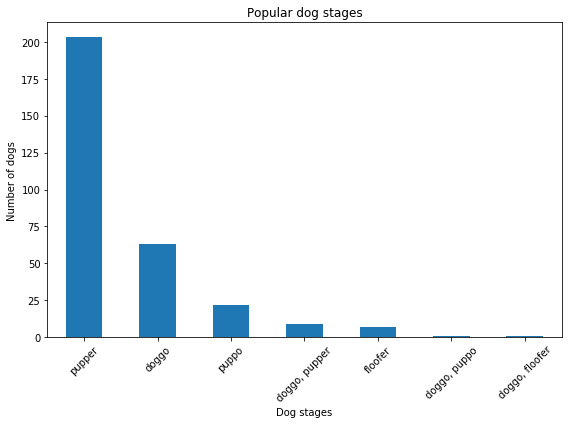

In [169]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(8,6))
df.dog_stages.value_counts().sort_values(ascending=False).plot.bar()
plt.title("Popular dog stages")
plt.xticks(rotation=45)
plt.xlabel("Dog stages")
plt.ylabel("Number of dogs");

#save pic
plt.savefig('dog_stages.png')

* what is the most popular dog name?

In [171]:
name_count = df.name.value_counts()
name_list = name_count.index.tolist()

In [172]:
from subprocess import check_output
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import locale

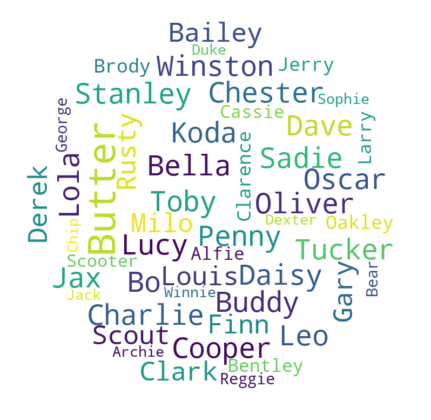

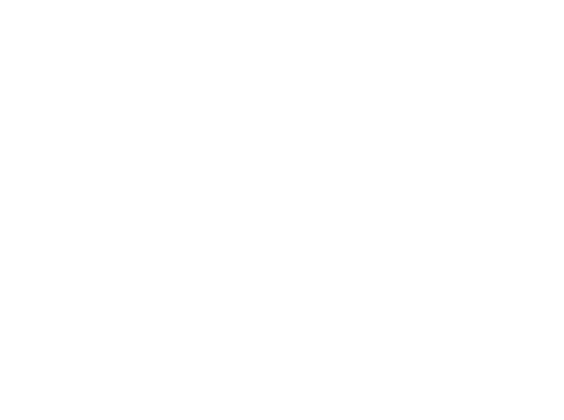

In [173]:
locale.setlocale(locale.LC_ALL, '')

rcParams['figure.figsize']=(8.0,6.0)
rcParams['savefig.dpi']=100
rcParams['font.size']=12                          
rcParams['figure.subplot.bottom']=.1 

round_mask = np.array(Image.open("mask.png"))

wordcloud = WordCloud(background_color='white',
                     mask=round_mask,
                     max_words=50,
                     max_font_size=70,
                     random_state=23,
                     ).generate(' '.join(name_list))

#save the wordcloud
wordcloud.to_file(os.path.join("dog_names.png"))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show();

* which breed of dog people love the most?

In [174]:
dog_fav = df.groupby('p1')['favorites'].sum().sort_values(ascending=False).head(6)
dog_fav

p1
golden_retriever      1696627
labrador_retriever    1123850
pembroke               994755
chihuahua              676441
samoyed                542991
french_bulldog         465738
Name: favorites, dtype: int64

In [175]:
dog_ret = df.groupby('p1')['retweets'].sum().sort_values(ascending=False).head(6)
dog_ret

p1
golden_retriever      502096
labrador_retriever    366682
pembroke              280367
chihuahua             220695
samoyed               184922
french_bulldog        121782
Name: retweets, dtype: int64

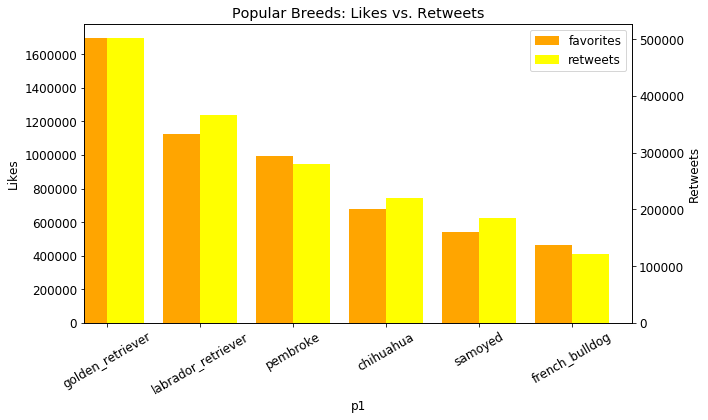

In [177]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


dog_fav.plot(figsize = (10,6), kind='bar', color='orange', ax=ax1, width=0.4, position=1, 
             title='Popular Breeds: Likes vs. Retweets')
dog_ret.plot(figsize = (10,6), kind='bar', color='yellow', ax=ax2, width=0.4, position=0)

ax1.set_ylabel('Likes')
ax2.set_ylabel('Retweets')
ax1.set_xticklabels(dog_fav.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

* Which breed of those popular dogs has the highest average rating?

In [178]:
rate1 = df.query('p1 == "golden_retriever"').rating.mean()
rate2 = df.query('p1 == "labrador_retriever"').rating.mean()
rate3 = df.query('p1 == "pembroke"').rating.mean()
rate4 = df.query('p1 == "chihuahua"').rating.mean()
rate5 = df.query('p1 == "samoyed"').rating.mean()
rate6 = df.query('p1 == "french_bulldog"').rating.mean()

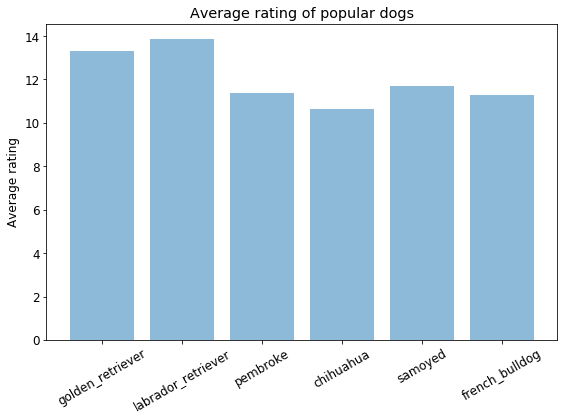

In [179]:
breeds = ['golden_retriever', 'labrador_retriever', 'pembroke', 'chihuahua', 'samoyed', 'french_bulldog']
rates = [rate1, rate2, rate3, rate4, rate5, rate6]
y_position = np.arange(len(breeds))

plt.bar(y_position, rates, align='center', alpha=0.5)
plt.xticks(y_position, breeds)
plt.xticks(rotation=30)
plt.ylabel("Average rating")
plt.title("Average rating of popular dogs")

plt.savefig('dog_ratings.png')
plt.show()